In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std),
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomCrop(32, 4)])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

train, val = torch.utils.data.random_split(trainset, [48000, 2000])
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    assert(in_channels == out_channels or in_channels * 2 == out_channels)
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=(out_channels // in_channels), padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    if in_channels * 2 == out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 1, stride=2, bias=False),
          nn.BatchNorm2d(out_channels))
    else:
      self.downsample = None
  
  def forward(self, x):
    residual = x
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    if self.downsample:
      residual = self.downsample(residual)
    return self.relu(residual + x)

In [7]:
class Resnet18(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
    self.layer1 = nn.Sequential(
        BasicBlock(64, 64),
        BasicBlock(64, 64))
    self.layer2 = nn.Sequential(
        BasicBlock(64, 128),
        BasicBlock(128, 128))
    self.layer3 = nn.Sequential(
        BasicBlock(128, 256),
        BasicBlock(256, 256))
    self.layer4 = nn.Sequential(
        BasicBlock(256, 512),
        BasicBlock(512, 512))
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, 1000)

  def forward(self, x):
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.avgpool(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

net = Resnet18()
net.to(device);

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
train_losses, val_losses = [], []
lowest_val_loss = np.inf
PATH = './cifar_net.pth'

In [10]:
for epoch in range(32):
    epoch_train_losses, epoch_val_losses = [], []
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        pred = net(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.detach().cpu().numpy())
    
    correct = 0
    total = 0
    for x, y in valloader:
        x, y = x.to(device), y.to(device)
        pred = net(x)
        loss = criterion(pred, y)
        epoch_val_losses.append(loss.detach().cpu().numpy())

        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    avg_train_loss = np.mean(epoch_train_losses)
    avg_val_loss = np.mean(epoch_val_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f'Epoch: {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct // total} %')
    if avg_val_loss < lowest_val_loss:
      lowest_val_loss = avg_val_loss
      torch.save(net.state_dict(), PATH)
            
print('Finished Training')

Epoch: 0, Training Loss: 1.5644307136535645, Validation Loss: 1.2965363264083862, Validation Accuracy: 54 %
Epoch: 1, Training Loss: 1.1905932426452637, Validation Loss: 1.0887458324432373, Validation Accuracy: 60 %
Epoch: 2, Training Loss: 1.0237760543823242, Validation Loss: 0.9488751292228699, Validation Accuracy: 66 %
Epoch: 3, Training Loss: 0.9162572622299194, Validation Loss: 0.8630196452140808, Validation Accuracy: 70 %
Epoch: 4, Training Loss: 0.8409570455551147, Validation Loss: 0.7965028285980225, Validation Accuracy: 73 %
Epoch: 5, Training Loss: 0.7798221707344055, Validation Loss: 0.7415028214454651, Validation Accuracy: 75 %
Epoch: 6, Training Loss: 0.7446063756942749, Validation Loss: 0.7523667812347412, Validation Accuracy: 74 %
Epoch: 7, Training Loss: 0.691513180732727, Validation Loss: 0.7283802032470703, Validation Accuracy: 73 %
Epoch: 8, Training Loss: 0.6591358780860901, Validation Loss: 0.7172034382820129, Validation Accuracy: 74 %
Epoch: 9, Training Loss: 0.62

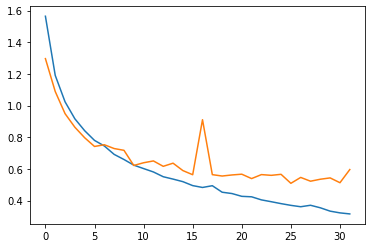

In [11]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show();

In [13]:
net = Resnet18()
net.load_state_dict(torch.load('./cifar_net.pth'))
net.to(device);

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 82 %
